In [1]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.util import random_noise
from torch.utils.data import TensorDataset, DataLoader
import time
import math

# Set the Device
device = 'cpu'
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = 'mps'
torch.manual_seed(189898)

In [2]:
# Add Noise Method
gauss_var = 0.2
sp_amount = 0.15
def add_noise(data, mode):
    if mode == "s&p":
        return torch.tensor(random_noise(data, mode=mode, amount=sp_amount), dtype=torch.float32) 
    else:
        return torch.tensor(random_noise(data, mode=mode, var=gauss_var), dtype=torch.float32)

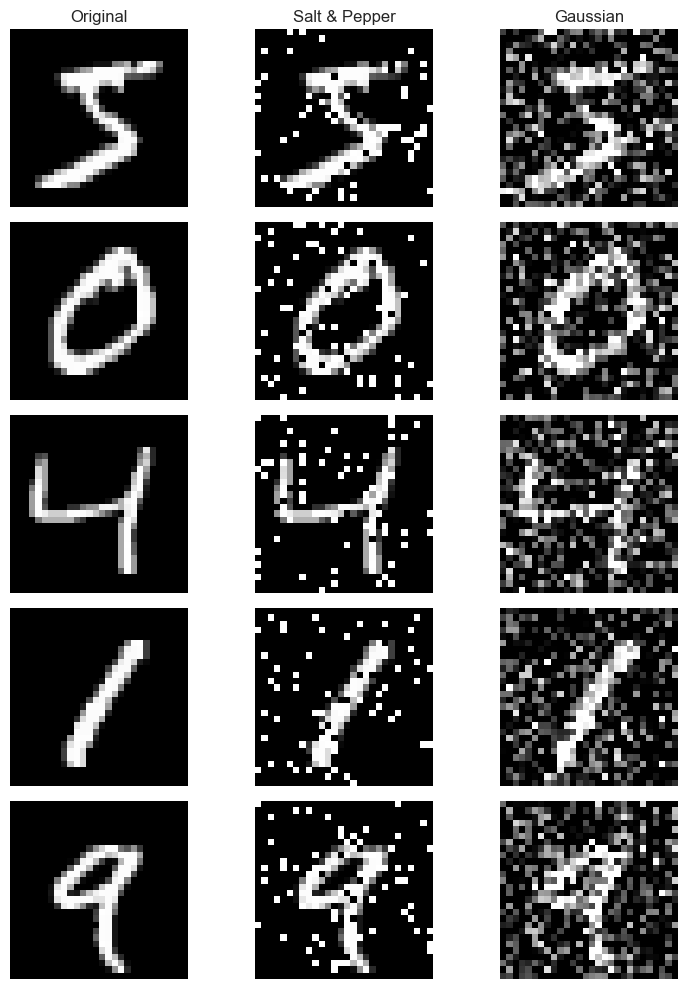

In [3]:
# Import the Dataset
mnist = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Initialize Training and Testing
X_train = mnist.data
X_test = mnist_test.data

# Normalize
X_train = X_train.float() / 255.0
X_test = X_test.float() / 255.0

# Reshape to have 4 Channels
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# Split X_test into Validation and Test
num_samples = X_test.size(0)
X_valid = X_test[:num_samples//2]
X_test = X_test[num_samples//2:]

# Apply Transformations
X_train_SP = add_noise(X_train, 's&p')
X_train_GN = add_noise(X_train, 'gaussian')
X_valid_SP = add_noise(X_valid, 's&p')
X_valid_GN = add_noise(X_valid, "gaussian")

# Function to plot images in a grid
def plot_images(original, salt_pepper, gaussian, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(8, 2 * num_images))
    for i in range(num_images):
        # Original image
        ax = axes[i, 0]
        ax.imshow(original[i, 0], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

        # Salt and Pepper image
        ax = axes[i, 1]
        ax.imshow(salt_pepper[i, 0], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Salt & Pepper')

        # Gaussian image
        ax = axes[i, 2]
        ax.imshow(gaussian[i, 0], cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Gaussian')

    plt.tight_layout()
    plt.show()

# Plotting the images
plot_images(X_train, X_train_SP, X_train_GN)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, conv_kernel=3, conv_pad=1, pool_kernel=2, pool_stride=2, c1=16, c2=32, l1=512, l2=50):
        super(Autoencoder, self).__init__()
        self.c1 = c1
        self.c2 = c2
        self.l1 = l1
        self.l2 = l2
        
        # Calculate the size of the output from the conv layers
        def conv_output_size(in_size, kernel_size, stride, padding):
            return (in_size - kernel_size + 2 * padding) // stride + 1

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, c1, kernel_size=conv_kernel, padding=conv_pad),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel, pool_stride),
            nn.Conv2d(c1, c2, kernel_size=conv_kernel, padding=conv_pad),
            nn.ReLU(),
            nn.MaxPool2d(pool_kernel, pool_stride)
        )

        # Calculate the dimensions for the Linear layer
        conv_dim = conv_output_size(conv_output_size(28, conv_kernel, 1, conv_pad), pool_kernel, pool_stride, 0)
        self.conv_dim = conv_output_size(conv_output_size(conv_dim, conv_kernel, 1, conv_pad), pool_kernel, pool_stride, 0)
        
        self.linear_input_size = self.conv_dim * self.conv_dim * c2

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.linear_input_size, l1),
            nn.ReLU(),
            nn.Linear(l1, l2),
            nn.ReLU(),
            nn.Linear(l2, self.linear_input_size),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(c2, c1, kernel_size=pool_kernel, stride=pool_stride, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(c1, 1, kernel_size=pool_kernel, stride=pool_stride, padding=0),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1) # Flatten for the fully connected layers
        x = self.fc(x)
        x = x.view(x.size(0), self.c2, self.conv_dim, self.conv_dim) # Reshape for the decoder
        x = x.view(-1, self.c2, self.conv_dim, self.conv_dim)
        x = self.decoder(x)
        return x


In [5]:
# Create the DataLoader
batch_size = 32

dataset_sp = TensorDataset(X_train_SP, X_train)
dataset_gn = TensorDataset(X_train_GN, X_train)
val_sp = TensorDataset(X_valid_SP, X_valid)
val_gn = TensorDataset(X_valid_GN, X_valid)

dataloader_sp = DataLoader(dataset_sp, batch_size=batch_size, shuffle=True)
dataloader_gn = DataLoader(dataset_gn, batch_size=batch_size, shuffle=True)
validation_sp = DataLoader(val_sp, batch_size=batch_size, shuffle=False)
validation_gn = DataLoader(val_gn, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=False)

In [6]:
def train_model(model, loader, lr=0.001, early_stop=False):
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    num_epochs = 10
    counter = 0
    best_score = math.inf
    for epoch in range(num_epochs):
        epoch_start = time.time()
        for noisy, original in loader:
            # Pass Images to Device
            noisy = noisy.to(device)
            original = original.to(device)
            
            # Forward Pass
            outputs = model(noisy)
            loss = criterion(outputs, original)
            
            # Early Stopping
            if early_stop:
                if loss.item() < best_score:
                    counter = 0
                    best_score = loss.item()
                else:
                    counter += 1
                if counter >= 3:
                    break
            
            # Backward Pass and Optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_runtime = time.time() - epoch_start
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Duration: {epoch_runtime:.2f}s')

In [7]:
# Validation
def validate_model(model, loader):
    criterion = nn.MSELoss()
    for noisy, original in loader:
        # Send Images to Device
        noisy = noisy.to(device)
        original = original.to(device)
        
        # Predict and Calculate Loss
        model.eval()
        with torch.no_grad():
            prediction = model(noisy)
        loss = criterion(prediction, original)
    print(f"Validation Loss: {loss.item():.4f}")
    return loss.item()

In [8]:
# Train the Network on Salt and Pepper Images
AutoNN_SP = Autoencoder().to(device)
train_model(AutoNN_SP, dataloader_sp)
sp_score = validate_model(AutoNN_SP, validation_sp)

Epoch [1/10], Loss: 0.0185, Duration: 8.08s
Epoch [2/10], Loss: 0.0164, Duration: 6.17s
Epoch [3/10], Loss: 0.0135, Duration: 6.15s
Epoch [4/10], Loss: 0.0111, Duration: 6.19s
Epoch [5/10], Loss: 0.0109, Duration: 6.14s
Epoch [6/10], Loss: 0.0122, Duration: 6.13s
Epoch [7/10], Loss: 0.0111, Duration: 6.16s
Epoch [8/10], Loss: 0.0120, Duration: 6.13s
Epoch [9/10], Loss: 0.0125, Duration: 6.20s
Epoch [10/10], Loss: 0.0102, Duration: 6.17s
Validation Loss: 0.0095


In [9]:
# Train the Network on Gaussian Noise Images
AutoNN_GN = Autoencoder().to(device)
train_model(AutoNN_GN, dataloader_gn)
gn_score = validate_model(AutoNN_GN, validation_gn)

Epoch [1/10], Loss: 0.0196, Duration: 6.32s
Epoch [2/10], Loss: 0.0146, Duration: 6.17s
Epoch [3/10], Loss: 0.0145, Duration: 6.21s
Epoch [4/10], Loss: 0.0147, Duration: 6.21s
Epoch [5/10], Loss: 0.0132, Duration: 6.13s
Epoch [6/10], Loss: 0.0139, Duration: 6.13s
Epoch [7/10], Loss: 0.0133, Duration: 6.14s
Epoch [8/10], Loss: 0.0131, Duration: 6.13s
Epoch [9/10], Loss: 0.0130, Duration: 6.14s
Epoch [10/10], Loss: 0.0140, Duration: 6.14s
Validation Loss: 0.0135


In [10]:
# Hyperparameter Tuning
def hp_tune(train, validation, parameters, type):
    best_params = []
    best_score = math.inf
    lrs = parameters[0]
    cs = parameters[1]
    ls = parameters[2]
    num_combinations = len(lrs) * len(cs) * len(ls)
    comb_count = 0
    print("Starting Hyperparameter Tuning Grid Search")
    ckpt = f"denoise_{type}.ckpt"
    for lr in lrs:
        for c in cs:
            for l in ls:
                model = Autoencoder(c1=c[0], c2=c[1], l1=l).to(device)
                print(f"\nCombination {comb_count + 1}/{num_combinations}")
                train_model(model, train, lr, True)
                score = validate_model(model, validation)
                if score < best_score:
                    best_score = score
                    best_params = [lr, c, l]
                    torch.save(model, ckpt)
                comb_count += 1
    print(f"\nBest Validation Loss: {best_score} \n lr: {best_params[0]}, c: {best_params[1]}, l: {best_params[2]}")
    return best_score

In [11]:
# Tune Hyperparameters for SP
search_start = time.time()
learning_rates = [0.0001, 0.001, 0.005, 0.01]
conv_sizes = [[16, 32], [10, 20], [25, 50]]
linear_layer = [256, 512, 1024]
pars = [learning_rates, conv_sizes, linear_layer]
search_score_sp = hp_tune(dataloader_sp, validation_sp, pars, "sp")
if search_score_sp < sp_score:
    AutoNN_SP = torch.load("denoise_sp.ckpt")
validate_model(AutoNN_SP, validation_sp)
print(f"Hyperparameter Grid Search Duration: {(time.time() - search_start):.2f}")

Starting Hyperparameter Tuning Grid Search

Combination 1/36
Epoch [1/10], Loss: 0.0968, Duration: 0.02s
Epoch [2/10], Loss: 0.0985, Duration: 0.02s
Epoch [3/10], Loss: 0.0959, Duration: 0.00s
Epoch [4/10], Loss: 0.0952, Duration: 0.00s
Epoch [5/10], Loss: 0.1040, Duration: 0.00s
Epoch [6/10], Loss: 0.0951, Duration: 0.00s
Epoch [7/10], Loss: 0.1056, Duration: 0.00s
Epoch [8/10], Loss: 0.1027, Duration: 0.00s
Epoch [9/10], Loss: 0.0974, Duration: 0.00s
Epoch [10/10], Loss: 0.0927, Duration: 0.00s
Validation Loss: 0.1066

Combination 2/36
Epoch [1/10], Loss: 0.1191, Duration: 0.03s
Epoch [2/10], Loss: 0.1201, Duration: 0.00s
Epoch [3/10], Loss: 0.1314, Duration: 0.00s
Epoch [4/10], Loss: 0.1034, Duration: 0.00s
Epoch [5/10], Loss: 0.1117, Duration: 0.00s
Epoch [6/10], Loss: 0.1134, Duration: 0.00s
Epoch [7/10], Loss: 0.1178, Duration: 0.00s
Epoch [8/10], Loss: 0.1242, Duration: 0.00s
Epoch [9/10], Loss: 0.1131, Duration: 0.00s
Epoch [10/10], Loss: 0.1139, Duration: 0.00s
Validation Loss

In [12]:
# Tune Hyperparameters for GN
search_start = time.time()
learning_rates = [0.0001, 0.001, 0.005, 0.01]
conv_sizes = [[16, 32], [10, 20], [25, 50]]
linear_layer = [256, 512, 1024]
pars = [learning_rates, conv_sizes, linear_layer]
search_score_gn = hp_tune(dataloader_gn, validation_gn, pars, "gn")
if search_score_gn < gn_score:
    AutoNN_GN = torch.load("denoise_gn.ckpt")
validate_model(AutoNN_GN, validation_gn)
print(f"Hyperparameter Grid Search Duration: {(time.time() - search_start):.2f}")

Starting Hyperparameter Tuning Grid Search

Combination 1/36
Epoch [1/10], Loss: 0.1094, Duration: 0.02s
Epoch [2/10], Loss: 0.1151, Duration: 0.00s
Epoch [3/10], Loss: 0.1108, Duration: 0.00s
Epoch [4/10], Loss: 0.1094, Duration: 0.00s
Epoch [5/10], Loss: 0.1153, Duration: 0.00s
Epoch [6/10], Loss: 0.1142, Duration: 0.00s
Epoch [7/10], Loss: 0.1233, Duration: 0.00s
Epoch [8/10], Loss: 0.1142, Duration: 0.00s
Epoch [9/10], Loss: 0.1165, Duration: 0.00s
Epoch [10/10], Loss: 0.1168, Duration: 0.00s
Validation Loss: 0.1207

Combination 2/36
Epoch [1/10], Loss: 0.1046, Duration: 0.03s
Epoch [2/10], Loss: 0.1073, Duration: 0.00s
Epoch [3/10], Loss: 0.1228, Duration: 0.00s
Epoch [4/10], Loss: 0.1166, Duration: 0.00s
Epoch [5/10], Loss: 0.1095, Duration: 0.00s
Epoch [6/10], Loss: 0.1116, Duration: 0.00s
Epoch [7/10], Loss: 0.1150, Duration: 0.02s
Epoch [8/10], Loss: 0.1238, Duration: 0.00s
Epoch [9/10], Loss: 0.1099, Duration: 0.01s
Epoch [10/10], Loss: 0.1165, Duration: 0.00s
Validation Loss

In [13]:
def denoise(model, test_images):
    model.eval()
    test_images = test_images.to(device)
    with torch.no_grad():
        denoised = model(test_images)
    return denoised.cpu()

In [14]:
def plot_images(original, noisy, denoised, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 2 * num_images))
    for i in range(num_images):
        # Original image
        ax = axes[i, 0]
        ax.imshow(original[i].squeeze(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Original')

        # Noisy image
        ax = axes[i, 1]
        ax.imshow(noisy[i].squeeze(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Noisy')

        # Denoised image
        ax = axes[i, 2]
        ax.imshow(denoised[i].squeeze(), cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title('Denoised')

    plt.tight_layout()
    plt.show()

In [15]:
def test_error(denoised, original, n_images):
    criterion = nn.MSELoss()
    error_sum = 0
    for i in range(n_images):
        loss = criterion(denoised[i], original[i])
        error_sum += loss.item()
    return error_sum / n_images

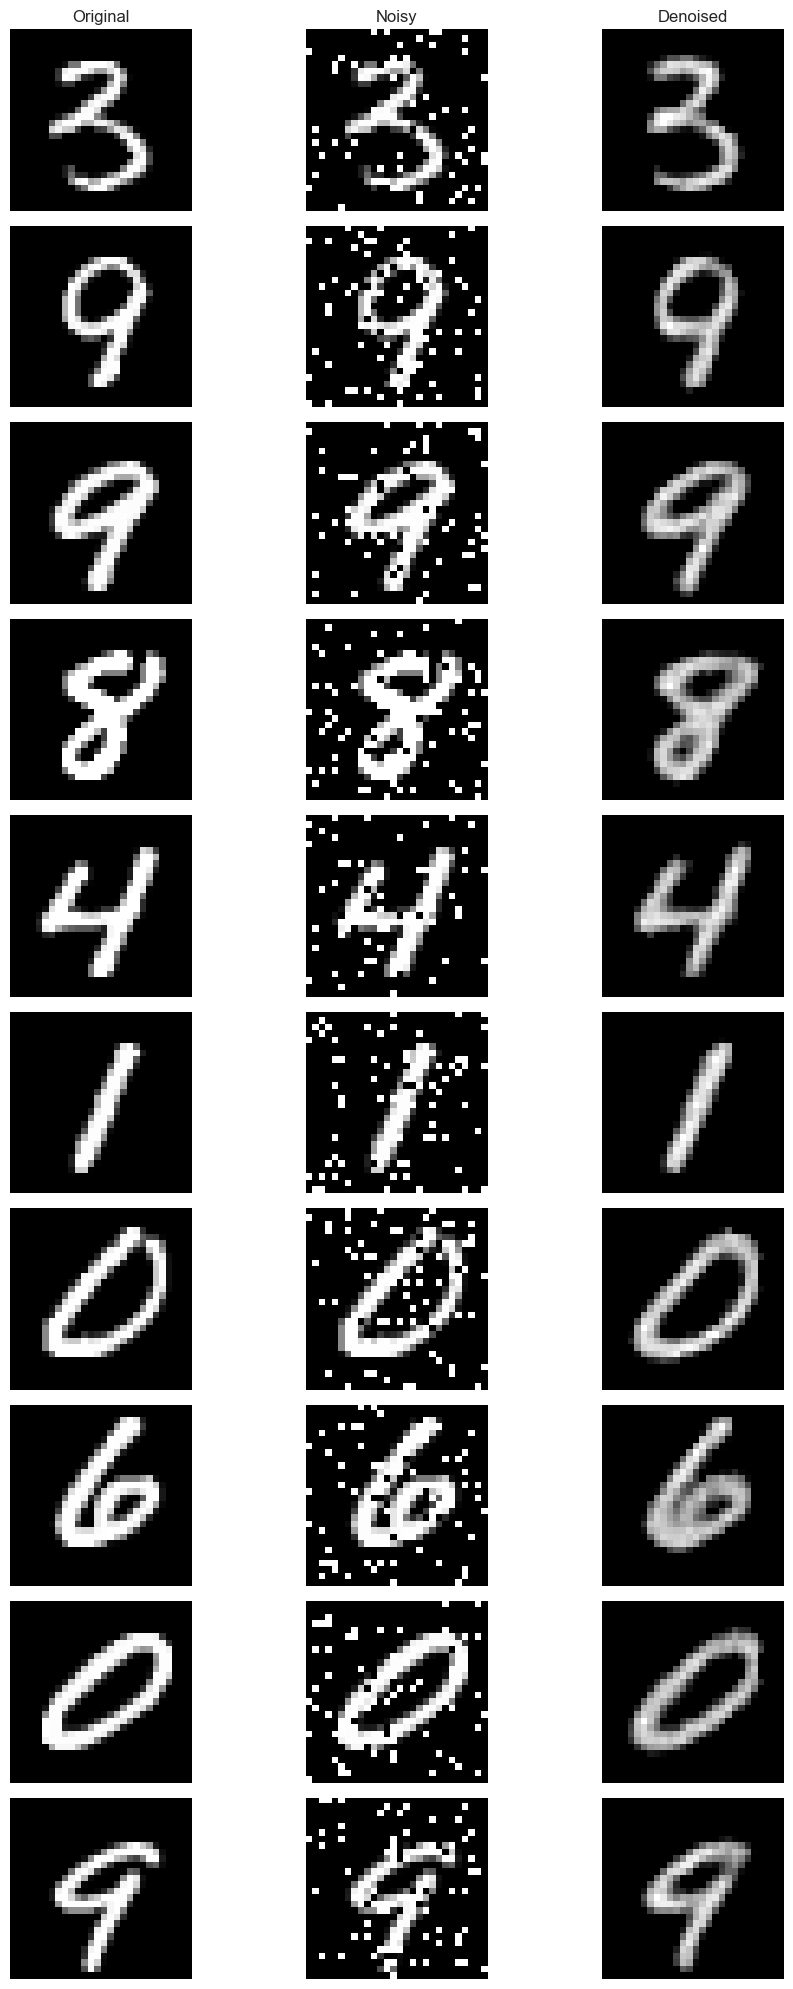

For 10 Test Images: Test Error = 0.009859364200383424


In [16]:
# Corrupt Test Images with SP and Pass them to AutoNN_SP
for test_imgs in test_loader:
    noisy_test = add_noise(test_imgs, 's&p')
    denoised_test = denoise(AutoNN_SP, noisy_test)
    
    # Plot the Results
    n_images = 10
    plot_images(test_imgs, noisy_test, denoised_test, num_images=n_images)
    
    # Report the Test Error
    test_error_sp = test_error(denoised_test, test_imgs, n_images)
    print(f"For {n_images} Test Images: Test Error = {test_error_sp}")
    break

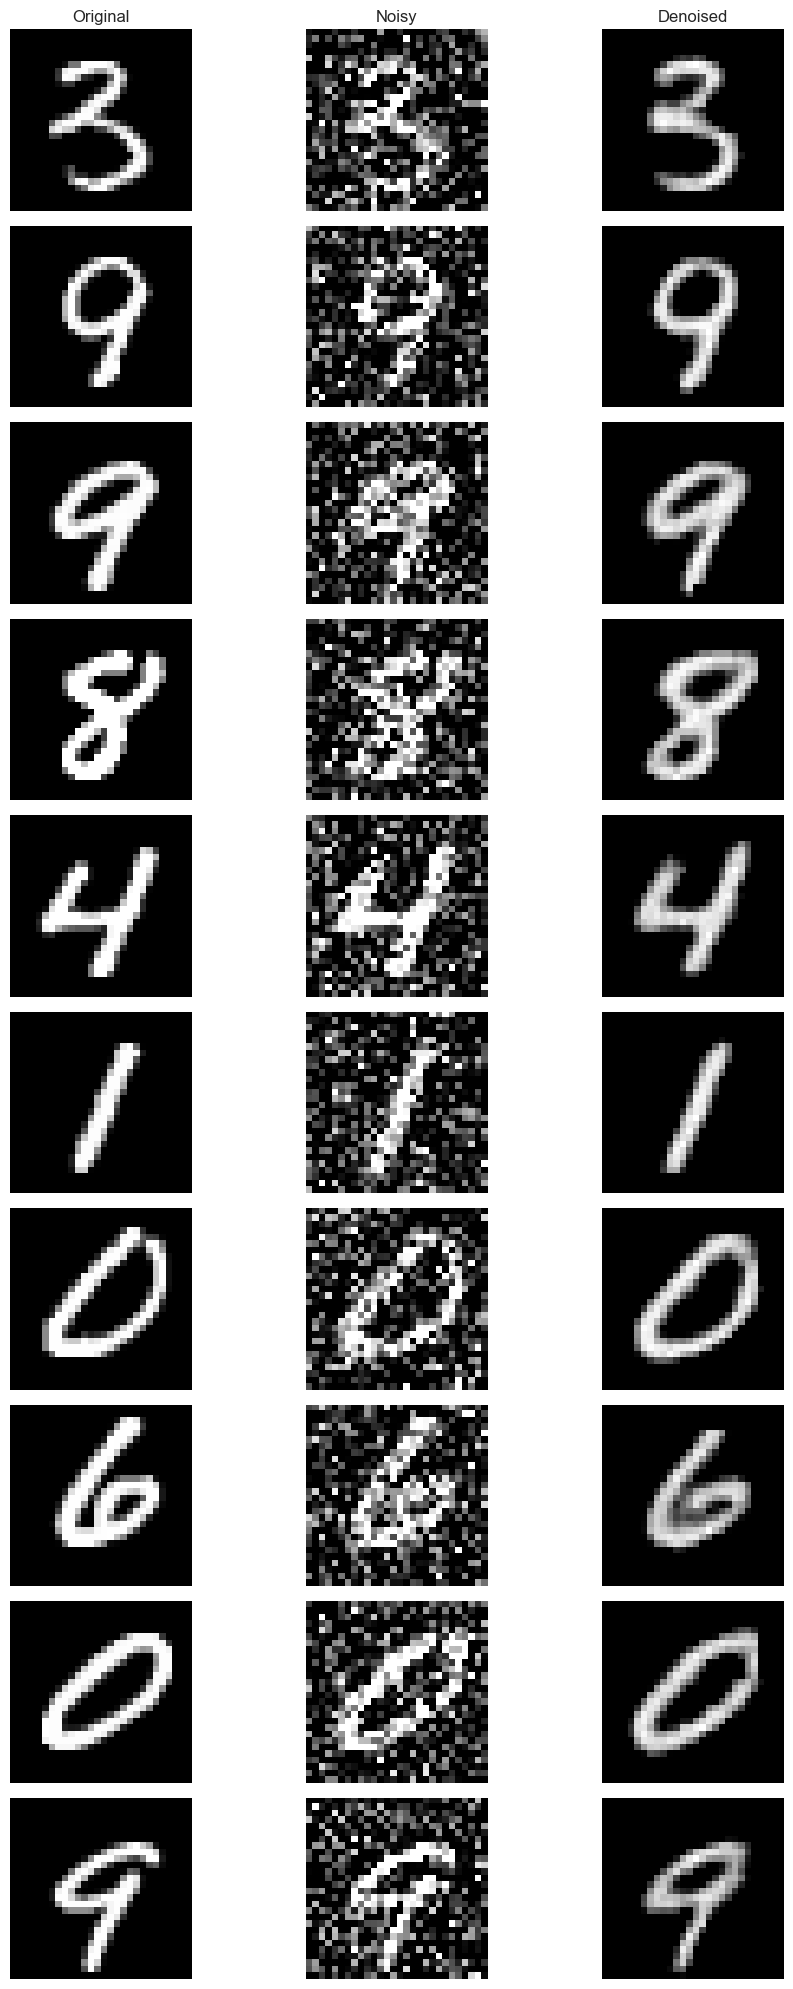

For 10 Test Images: Test Error = 0.013549378234893083


In [17]:
# Corrupt Test Images with GN and Pass them to AutoNN_GN
for test_imgs in test_loader:
    noisy_test = add_noise(test_imgs, 'gaussian', )
    denoised_test = denoise(AutoNN_GN, noisy_test)
    
    # Plot the Results
    n_images = 10
    plot_images(test_imgs, noisy_test, denoised_test, num_images=n_images)
    
    # Report the Test Error
    test_error_gn = test_error(denoised_test, test_imgs, n_images)
    print(f"For {n_images} Test Images: Test Error = {test_error_gn}")
    break
